# 1d base

In [1]:
import numpy as np
import os
import tensorflow as tf
data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

print("✅")

✅


In [2]:
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)
print("✅")

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)
✅


In [3]:
import IPython.display as ipd
import random

# 데이터 선택
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  24520
Wave data shape :  (8000,)
label :  ['go']


In [4]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value
print("✅")

✅


In [5]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)
print("✅")

✅


In [6]:
from sklearn.model_selection import train_test_split

sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav)

train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, sr, 1])
print("✅")

[[ 2.5644386e-04  6.8105175e-04  3.0988813e-04 ...  5.7385373e-04
   1.1826350e-04  3.0603696e-04]
 [-4.9615926e-03 -1.2397108e-02 -2.2223627e-02 ...  3.0881453e-02
   2.4428198e-02  1.5579112e-02]
 [-8.5820872e-03 -1.9576330e-02 -2.9794924e-02 ...  2.3294568e-02
   3.7833657e-02  3.1417649e-02]
 ...
 [-1.3062210e-01  4.1356619e-02  1.9407178e-01 ... -1.3186113e-02
  -3.1432253e-01 -2.0972928e-01]
 [ 3.2846029e-03  4.3794932e-03  9.1929105e-05 ...  1.5939197e-03
   2.2257254e-03 -2.4256920e-03]
 [ 3.2938202e-03  4.7343327e-03  8.2739476e-05 ...  2.4956807e-03
   1.9981219e-03 -1.8741293e-03]]
✅


In [7]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)
print("✅")

train data :  (45558, 8000, 1)
train labels :  (45558,)
test data :  (5062, 8000, 1)
test labels :  (5062,)
✅


In [8]:
batch_size = 64
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/aiffel0042/aiffel/speech_recognition/models/wav'

In [9]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label
print("✅")

✅


In [10]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
✅


In [11]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 8000, 32)          320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8000, 32)          9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4000, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4000, 64)          18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4000, 64)          36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2000, 64)         

In [12]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [13]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [14]:
#30분 내외 소요
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
711/711 [==============================] - ETA: 0s - loss: 1.4181 - accuracy: 0.5293
Epoch 00001: val_loss improved from inf to 0.99823, saving model to /home/aiffel0042/aiffel/speech_recognition/models/wav
711/711 [==============================] - 135s 190ms/step - loss: 1.4181 - accuracy: 0.5293 - val_loss: 0.9982 - val_accuracy: 0.6826
Epoch 2/10
711/711 [==============================] - ETA: 0s - loss: 0.8461 - accuracy: 0.7423
Epoch 00002: val_loss improved from 0.99823 to 0.83588, saving model to /home/aiffel0042/aiffel/speech_recognition/models/wav
711/711 [==============================] - 137s 193ms/step - loss: 0.8461 - accuracy: 0.7423 - val_loss: 0.8359 - val_accuracy: 0.7397
Epoch 3/10
711/711 [==============================] - ETA: 0s - loss: 0.6314 - accuracy: 0.8118
Epoch 00003: val_loss improved from 0.83588 to 0.77852, saving model to /home/aiffel0042/aiffel/speech_recognition/models/wav
711/711 [==============================] - 138s 194ms/step - loss: 0

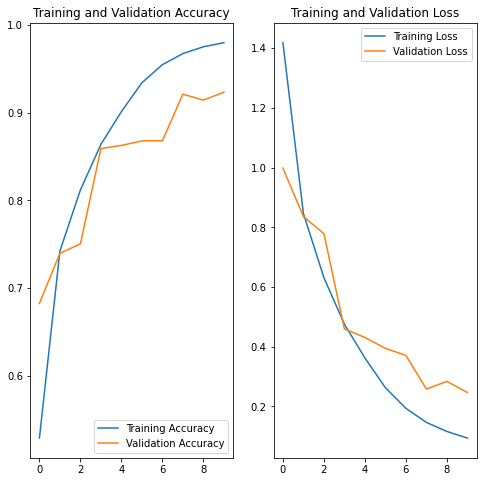

✅


In [15]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

In [16]:
model_wav.load_weights(checkpoint_dir)
print("✅")

✅


In [17]:
results = model_wav.evaluate(test_dataset)
print("✅")

80/80 [==============================] - 7s 93ms/step - loss: 0.2465 - accuracy: 0.9232
✅


In [18]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

loss value: 0.247
accuracy value: 92.3153%
✅


In [19]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  off


In [20]:
if np.argmax(y_pred_) == test_label[i]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
print("✅")

y_pred: off
✅


# 1d skip

In [21]:
input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 8000, 32)     320         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 8000, 32)     9248        conv1d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 4000, 32)     0           conv1d_11[0][0]                  
_______________________________________________________________________________________

In [22]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [23]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [24]:
#30분 내외 소요
history_wav_skip = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
711/711 [==============================] - ETA: 0s - loss: 1.2184 - accuracy: 0.6109
Epoch 00001: val_loss improved from inf to 0.84297, saving model to /home/aiffel0042/aiffel/speech_recognition/models/wav_skip
711/711 [==============================] - 164s 231ms/step - loss: 1.2184 - accuracy: 0.6109 - val_loss: 0.8430 - val_accuracy: 0.7237
Epoch 2/10
711/711 [==============================] - ETA: 0s - loss: 0.6608 - accuracy: 0.8072
Epoch 00002: val_loss improved from 0.84297 to 0.67793, saving model to /home/aiffel0042/aiffel/speech_recognition/models/wav_skip
711/711 [==============================] - 164s 231ms/step - loss: 0.6608 - accuracy: 0.8072 - val_loss: 0.6779 - val_accuracy: 0.7902
Epoch 3/10
711/711 [==============================] - ETA: 0s - loss: 0.4087 - accuracy: 0.8904
Epoch 00003: val_loss improved from 0.67793 to 0.40856, saving model to /home/aiffel0042/aiffel/speech_recognition/models/wav_skip
711/711 [==============================] - 164s 231ms

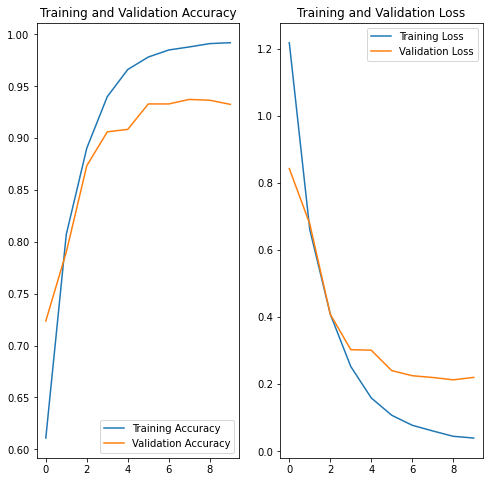

✅


In [25]:
import matplotlib.pyplot as plt

acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

In [26]:
# Evaluation 

model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

80/80 [==============================] - 6s 72ms/step - loss: 0.2127 - accuracy: 0.9366
loss value: 0.213
accuracy value: 93.6586%
✅


In [27]:
# Test 

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  off


In [28]:
if np.argmax(y_pred_) == test_label[i]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
print("✅")

y_pred: off
✅


# 2d Base

In [11]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return np.expand_dims(D,0)
print("✅")

✅


In [12]:
# 위에서 뽑았던 sample data
spec = wav2spec(data)
print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",spec.shape)

Waveform shape :  (8000,)
Spectrogram shape :  (1, 130, 126)


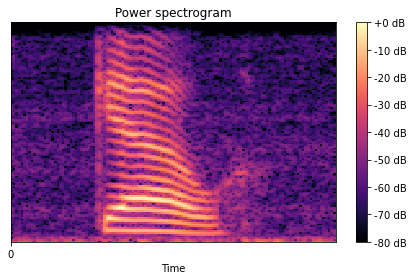

In [13]:
import librosa.display
import matplotlib.pyplot as plt
librosa.display.specshow(librosa.amplitude_to_db(np.squeeze(spec), ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

In [14]:
def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    
    D = (librosa.amplitude_to_db(np.abs(librosa.stft(wav.numpy(), n_fft=fft_size)), ref=np.max)+80)/80
    return D



In [15]:
train_wav = train_wav.reshape([-1, sr])
test_wav = test_wav.reshape([-1, sr])
def preprocess(wav, label):
    wav = tf.py_function(func=wav2spec,inp=[wav],Tout=[tf.float32])
    wav = tf.reshape(wav,[130,126,1])
    return wav, tf.one_hot(label, depth=12)


# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(preprocess)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)
# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(preprocess)
test_dataset = test_dataset.batch(batch_size=batch_size)


<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>


In [16]:
from tensorflow.keras import layers
input_tensor = layers.Input(shape=(130, 126, 1))
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256,activation='relu')(x)

output_tensor = layers.Dense(12,activation='softmax')(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 130, 126, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 130, 126, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 63, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 65, 63, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 31, 64)       

In [17]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [18]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [19]:
#30분 내외 소요
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
711/711 [==============================] - ETA: 0s - loss: 2.2357 - accuracy: 0.3737
Epoch 00001: val_loss improved from inf to 2.11384, saving model to /home/aiffel0042/aiffel/speech_recognition/models/wav
711/711 [==============================] - 110s 155ms/step - loss: 2.2357 - accuracy: 0.3737 - val_loss: 2.1138 - val_accuracy: 0.5018
Epoch 2/10
711/711 [==============================] - ETA: 0s - loss: 2.0186 - accuracy: 0.5992
Epoch 00002: val_loss improved from 2.11384 to 1.99130, saving model to /home/aiffel0042/aiffel/speech_recognition/models/wav
711/711 [==============================] - 110s 154ms/step - loss: 2.0186 - accuracy: 0.5992 - val_loss: 1.9913 - val_accuracy: 0.6254
Epoch 3/10
711/711 [==============================] - ETA: 0s - loss: 1.9780 - accuracy: 0.6404
Epoch 00003: val_loss improved from 1.99130 to 1.96566, saving model to /home/aiffel0042/aiffel/speech_recognition/models/wav
711/711 [==============================] - 110s 154ms/step - loss: 1

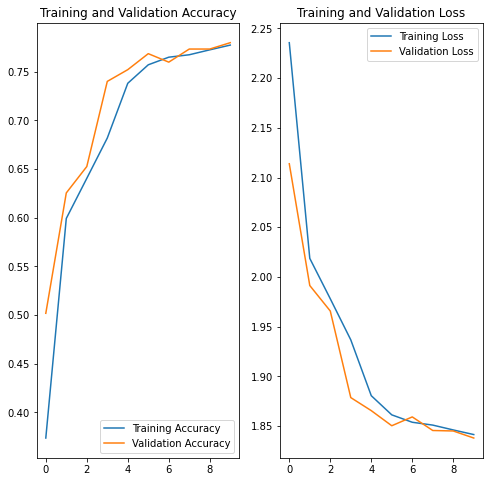

✅


In [20]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

In [21]:
model_wav.load_weights(checkpoint_dir)
print("✅")

✅


In [22]:
results = model_wav.evaluate(test_dataset)
print("✅")

80/80 [==============================] - 12s 146ms/step - loss: 1.8378 - accuracy: 0.7797
✅


In [23]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

loss value: 1.838
accuracy value: 77.9731%
✅


# 2d skip

In [25]:
from tensorflow.keras import layers
input_tensor = layers.Input(shape=(130, 126, 1))
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 3, padding='same', activation='relu')(skip_1)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 3, padding='same', activation='relu')(skip_2)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool2D()(x)


x = layers.Conv2D(256, 3, padding='same', activation='relu')(skip_3)
x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
skip_4 = layers.MaxPool2D()(x)

x = layers.Conv2D(512, 3, padding='same', activation='relu')(skip_4)
x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
x = tf.concat([x, skip_4], -1)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256,activation='relu')(x)

output_tensor = layers.Dense(12,activation='softmax')(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 130, 126, 1) 0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 130, 126, 32) 320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 130, 126, 32) 9248        conv2d_17[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 65, 63, 32)   0           conv2d_18[0][0]                  
_______________________________________________________________________________________

In [26]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [27]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [28]:
#30분 내외 소요
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
711/711 [==============================] - ETA: 0s - loss: 2.2094 - accuracy: 0.4021
Epoch 00001: val_loss improved from inf to 2.03384, saving model to /home/aiffel0042/aiffel/speech_recognition/models/wav
711/711 [==============================] - 128s 180ms/step - loss: 2.2094 - accuracy: 0.4021 - val_loss: 2.0338 - val_accuracy: 0.5845
Epoch 2/10
711/711 [==============================] - ETA: 0s - loss: 2.0089 - accuracy: 0.6081
Epoch 00002: val_loss improved from 2.03384 to 1.97487, saving model to /home/aiffel0042/aiffel/speech_recognition/models/wav
711/711 [==============================] - 117s 165ms/step - loss: 2.0089 - accuracy: 0.6081 - val_loss: 1.9749 - val_accuracy: 0.6430
Epoch 3/10
711/711 [==============================] - ETA: 0s - loss: 1.9632 - accuracy: 0.6542
Epoch 00003: val_loss improved from 1.97487 to 1.94704, saving model to /home/aiffel0042/aiffel/speech_recognition/models/wav
711/711 [==============================] - 117s 164ms/step - loss: 1

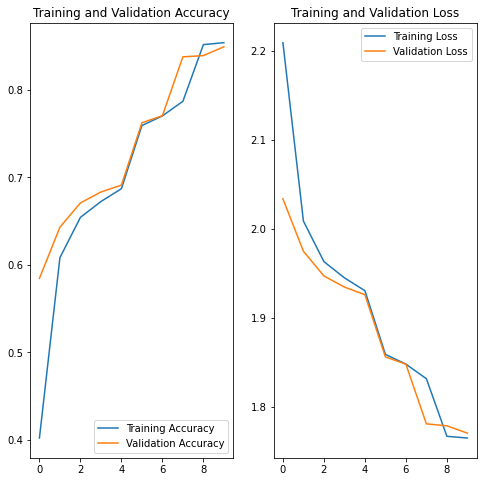

✅


In [29]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

In [30]:
model_wav.load_weights(checkpoint_dir)
print("✅")

✅


In [31]:
results = model_wav.evaluate(test_dataset)
print("✅")

80/80 [==============================] - 8s 97ms/step - loss: 1.7704 - accuracy: 0.8491
✅


In [32]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

loss value: 1.770
accuracy value: 84.9072%
✅


##### base model accuracy value: 77.9731%
##### skip model accuracy value: 84.9072%
##### 이렇게 하는 게 맞는지는 모르겠다.